<a href="https://colab.research.google.com/github/Nikelroid/DeepLearning_Project/blob/main/Phase-1/project_phase1_subsection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading data onto the disk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My Drive/

/content/drive/My Drive


In [ ]:
# !ls drive/My\ Drive/

In [3]:
!cp train_ende.zip .
!cp test.zip .

cp: cannot stat 'train_ende.zip': No such file or directory
cp: cannot stat 'test.zip': No such file or directory


In [4]:
! git clone https://github.com/XL2248/MSCTD

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 14.88 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [5]:
!cp MSCTD/MSCTD_data/ende/english_*.txt .
!cp MSCTD/MSCTD_data/ende/image_index_*.txt .
!cp MSCTD/MSCTD_data/ende/sentiment_*.txt .

In [6]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
!gdown --id 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
To: /content/drive/MyDrive/train_ende.zip
100% 2.90G/2.90G [00:38<00:00, 75.0MB/s]
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
To: /content/drive/MyDrive/test.zip
100% 641M/641M [00:05<00:00, 114

In [8]:
%%bash
for x in *.zip
do
  unzip -qq $x
done;

In [7]:
!mkdir dataset
!cd dataset; mkdir train test dev

In [ ]:
#!mv --help

In [9]:
!mv *train* dataset/train
!mv *test* dataset/test
!mv *dev* dataset/dev

In [10]:
!ls dataset/train/train_ende | head

0.jpg
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg


In [11]:
!head dataset/train/english_train.txt

Okay. I'm confused.
You don't care if I go to Paris with Jane,
I'm sorry. I have to tell you something,
I have to go.
I'm an accessory to murder.
I think you've helped enough.
Gaby, please. I can't stand this anymore.
Can't we talk for a minute?
To be honest,
Wait. What do you mean?


In [12]:
!head dataset/train/sentiment_train.txt

0
0
1
1
1
2
1
1
0
1


In [13]:
!head dataset/train/image_index_train.txt

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[10, 11, 12, 13, 14, 15, 16]
[17, 18, 19, 20, 21]
[22, 23, 24, 25, 26]
[27, 28, 29, 30, 31]
[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
[43, 44, 45, 46, 47, 48, 49, 50, 51]
[52, 53, 54, 55, 56, 57]
[58, 59, 60, 61, 62]


#Dataset and Dataloader

In [14]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 29.1 MB/s eta 0:00:00


In [15]:
import torch
from torchvision import transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import groupby
import seaborn as sns
import cv2
from mtcnn.mtcnn import MTCNN
# import linecache

In [16]:
class MSCTD_Dataset (Dataset):
  def __init__(self, dataset_dir, images_dir, conversation_dir, texts, sentiments, transform=None):
    self.dataset_path = Path(dataset_dir)
    self.images_path = self.dataset_path / images_dir
    self.sentiment_path = self.dataset_path / sentiments
    self.text_path = self.dataset_path / texts
    self.conversations_path = self.dataset_path / conversation_dir

    self.transform = transform

    with open(self.sentiment_path, 'r') as f:
      self.length = len(f.readlines())

    with open(self.text_path, 'r') as f:
        self.texts = f.read().splitlines()

    with open(self.sentiment_path, 'r') as f:
        self.sentiments = np.array(f.read().splitlines()).astype("int32")
    
    with open(self.conversations_path, 'r') as f:
        self.conversations = np.array(f.read().splitlines())
    
  def __len__(self):
        return self.length

  def __getitem__(self, idx):
        img_path = self.images_path / f'{idx}.jpg'
        image = Image.open(img_path)
        # image = read_image(str(img_path))
        if self.transform:
            image = self.transform(image)
       
        txt = self.texts[idx].strip()
        
        sentiment = self.sentiments[idx]

        data_dict = {"text":txt,
                     "image":image,
                     "sentiment":sentiment}
        return data_dict

In [17]:
trainset = MSCTD_Dataset('dataset/train', 'train_ende', 'image_index_train.txt', 'english_train.txt', 'sentiment_train.txt')

In [19]:
text, image, sentiment = trainset[14787].values()

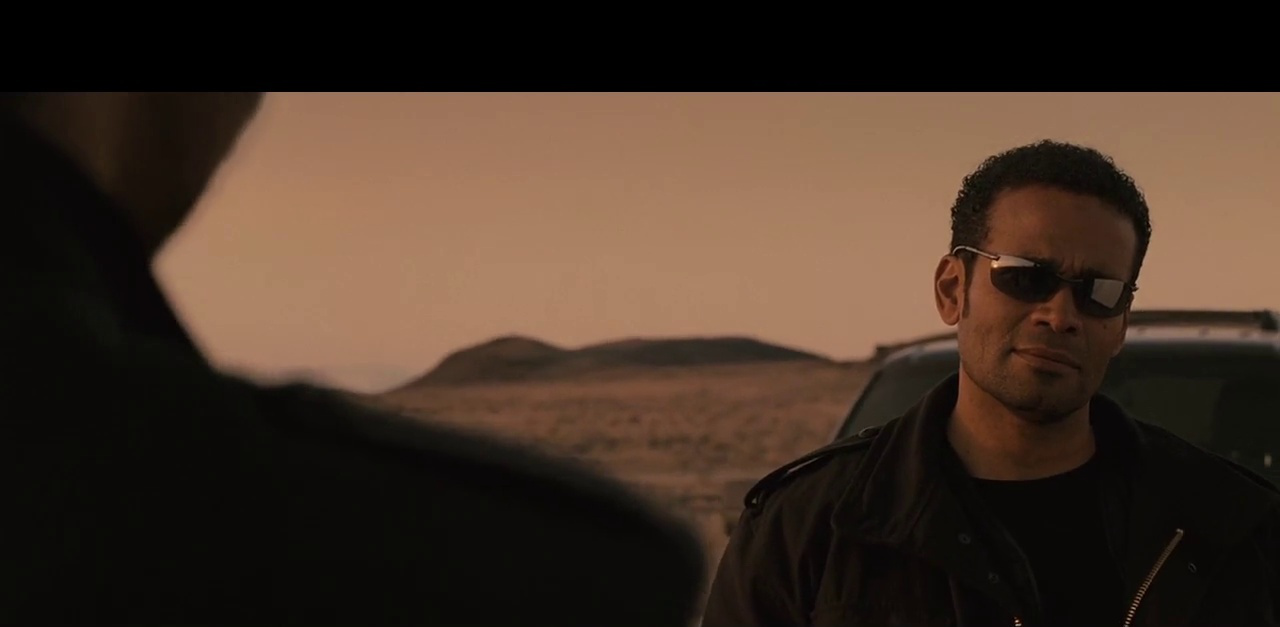

In [20]:
image

#Section 1 :



##Subsection 1:

###First step: localization step

In [21]:
!pip install git+https://github.com/elliottzheng/face-detection.git@master
from skimage import io
from face_detection import RetinaFace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/elliottzheng/face-detection.git (to revision master) to /tmp/pip-req-build-co3vcf5d
  Running command git clone --filter=blob:none --quiet https://github.com/elliottzheng/face-detection.git /tmp/pip-req-build-co3vcf5d
  Resolved https://github.com/elliottzheng/face-detection.git to commit 096cbf438dab07a313dac3044653d211725d64ba
  Preparing metadata (setup.py) ... done
  Created wheel for face-detection: filename=face_detection-1.0.5-py3-none-any.whl size=1638328 sha256=d5a831fc98ec2295cae0d6f15d4e2ba1cbc3a2cae93ce3354923567b93580f2f
  Stored in directory: /tmp/pip-ephem-wheel-cache-brkyak1k/wheels/99/88/1d/b1e416a6280864d3235db4c27ad9efd5eae332f5e8fbb2ff3a
Successfully built face-detection


In [22]:
main_detector = RetinaFace(gpu_id=0)
def face_detector(image):
    faces_boundaries = main_detector(image)
    faces = []
    for i in range(len(faces_boundaries)):
      stats, _, score = faces_boundaries[i]
      stats = stats.astype(int)
      if score>0.95:
        faces.append(Image.fromarray(image[stats[1]:stats[3],stats[0]:stats[2]]))
    return faces

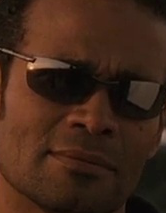

In [23]:
_,img,_ = trainset[14787].values()
img = np.array(img.convert('RGB'))
faces = face_detector(img)
faces[0]

###Second step: CNN model

In [24]:
!wget https://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz

--2023-02-06 06:06:18--  https://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_torch.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541127779 (516M) [application/x-gzip]
Saving to: ‘vgg_face_torch.tar.gz’

vgg_face_torch.tar. 100%[===================>] 516.06M  27.5MB/s    in 20s     

2023-02-06 06:06:39 (25.2 MB/s) - ‘vgg_face_torch.tar.gz’ saved [541127779/541127779]



In [25]:
import tarfile

file = tarfile.open('vgg_face_torch.tar.gz')

file.extractall('./dataset')
  
file.close()

In [28]:
Read = torch.load("./dataset/vgg_face_torch/VGG_FACE.t7")

UnpicklingError: ignored

In [ ]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
      param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048,10)
)

model = model.to(device)

loss_fn = nn.CrossEntropyLoss().to(device)

params = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params.append(param)
        print(f"parameter to learn : {name}")

optimizer = torch.optim.Adam(params)

In [ ]:
face_numbers = []
from tqdm import tqdm
for i in tqdm(range(len(trainset))):
  _,img,_ = trainset[i].values()
  #display(img)
  img = img.convert('RGB')
  number = face_detector(np.array(img))
  #print (number)
  face_numbers.append(number)

faces = np.array(face_numbers)

100%|██████████| 20240/20240 [53:17<00:00,  6.33it/s]
